In [ ]:
!pip install pydicom python-gdcm pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [17]:
import pydicom
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops

In [2]:
data_path = '/data/datasets/rsna-breast-cancer-detection/'

In [3]:
# Load metadata
train_metadata = pd.read_csv(data_path + 'train.csv')
test_metadata = pd.read_csv(data_path + 'test.csv')

# Display the first few rows of the train metadata
print("Train Metadata:")
print(train_metadata.head())

# Display the first few rows of the test metadata
print("Test Metadata:")
print(test_metadata.head())

Train Metadata:
   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
Test Metadata:
   site_id  patient_id    image_id laterality view  age 

In [4]:
# Function to load a DICOM image
def load_dicom_image(path):
    dicom_file = pydicom.dcmread(path)
    image_data = dicom_file.pixel_array
    if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
        # Handle JPEG 2000 compression if necessary
        # You might need additional handling here depending on the compression
        pass
    return image_data

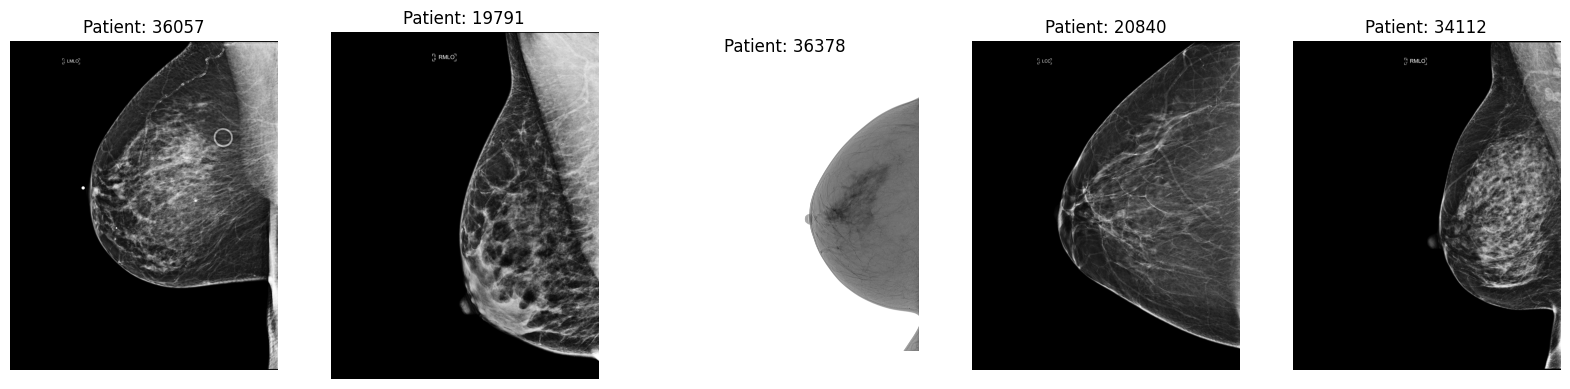

In [10]:
# Example: Load and display an image
# generate 5 random number
rand_patients = np.random.randint(0, len(train_metadata), 5)
# sample image path
example_image_paths = [data_path + 'train_images/' + str(train_metadata.iloc[rand_patient]['patient_id']) + '/' + str(train_metadata.iloc[rand_patient]['image_id']) + '.dcm' for rand_patient in rand_patients]

plt.figure(figsize=(20, 20))

for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image = load_dicom_image(image)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Patient: ' + str(train_metadata.iloc[rand_patients[i]]['patient_id']))
    else:
        print('Dicom file not found!')
        
plt.show()

In [11]:
# Statistical analysis of metadata
print("\nAge Distribution in Train Set:")
print(train_metadata['age'].describe())

# Checking for class imbalance
print("\nCancer Class Distribution:")
print(train_metadata['cancer'].value_counts(normalize=True))


Age Distribution in Train Set:
count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Cancer Class Distribution:
cancer
0    0.978832
1    0.021168
Name: proportion, dtype: float64


In [19]:
def image_statistics(image_path):
    try:
        dicom_image = load_dicom_image(image_path)
        image = Image.fromarray(np.uint8(dicom_image)) 
        stat = ImageStat.Stat(image)
        return {"mean": stat.mean, "rms": stat.rms, "variance": stat.var}
    except Exception as e:
        print(f"Error in image_statistics: {e}")
        return None

# Example usage
stats = image_statistics(example_image_paths[0])
print(stats)

{'mean': [57.93568442418025], 'rms': [99.24548013606938], 'variance': [6493.12179774074]}


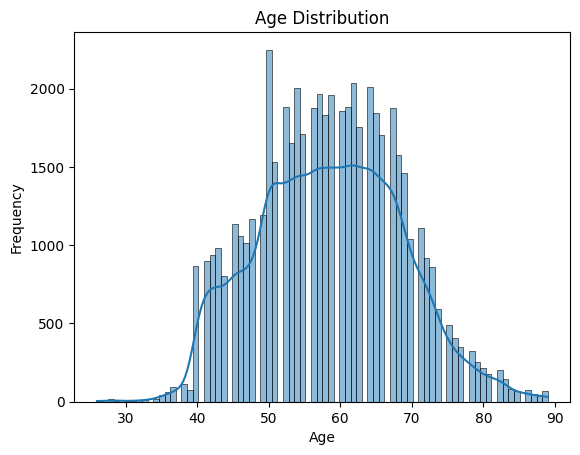

In [44]:
# Example: Plotting distribution of age
sns.histplot(train_metadata['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Example: Correlation heatmap
correlation_matrix = train_metadata.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
# Crosstab between 'biopsy' and 'cancer'
pd.crosstab(train_metadata['biopsy'], train_metadata['cancer'])

cancer,0,1
biopsy,,
0,51737,0
1,1811,1158


In [36]:
def texture_analysis(image_path):
    try:
        image = load_dicom_image(image_path)
        # Ensure image is in the right format (2D and uint8)
        if image.ndim == 3:
            image = image[:, :, 0]  # Assuming grayscale, take the first channel
        image = (image / np.max(image) * 255).astype('uint8')  # Normalize and convert to uint8
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        return contrast
    except Exception as e:
        print(f"Error in texture_analysis: {e}")
        return None

In [37]:
# Create a new column for contrast
train_metadata['contrast'] = None

# Iterate over the DataFrame and apply texture analysis
for index, row in train_metadata.iterrows():
    image_path = f"{data_path}/train_images/{row['patient_id']}/{row['image_id']}.dcm"
    contrast = texture_analysis(image_path)
    train_metadata.at[index, 'contrast'] = contrast


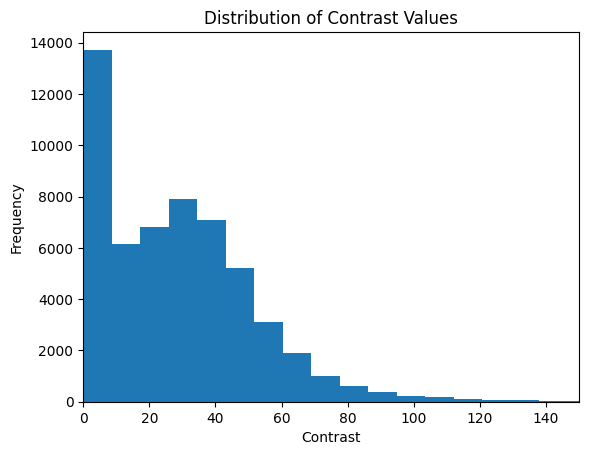

In [43]:
plt.hist(train_metadata['contrast'], bins=500)
plt.title('Distribution of Contrast Values')
plt.xlim(0, 150)
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='site_id', ylabel='age'>

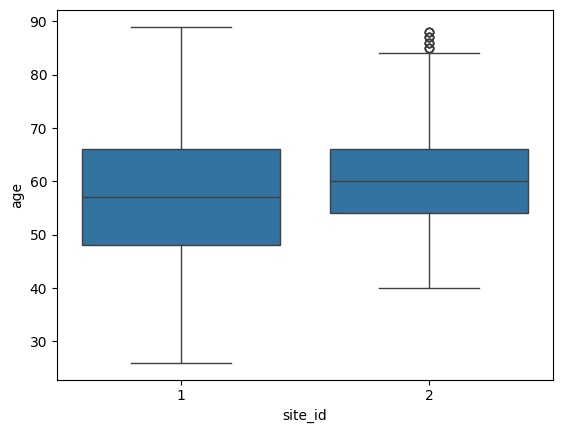

In [24]:
# Boxplot for a feature across different sites
sns.boxplot(x='site_id', y='age', data=train_metadata)

In [25]:
missing_data = train_metadata.isnull().sum()
print(missing_data)

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


<Axes: >

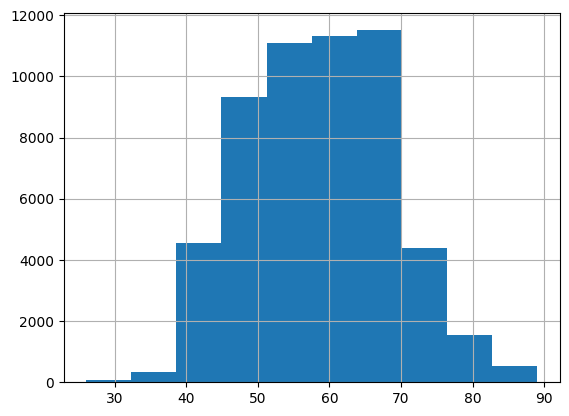

In [31]:
# Age distribution
train_metadata['age'].hist()

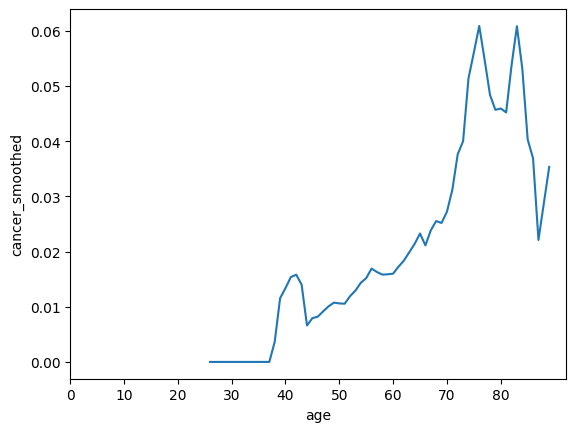

In [35]:
# Age vs. cancer rate, with age labels on x-axis only every 10 years
# Determine cancer rate for each age
age_cancer_rate = train_metadata.groupby('age')['cancer'].mean().reset_index()

# Interpolating missing ages (assuming age is a continuous variable)
age_cancer_rate['cancer_smoothed'] = age_cancer_rate['cancer'].rolling(window=5, min_periods=1).mean()

# Plot with smoothing
sns.lineplot(x='age', y='cancer_smoothed', data=age_cancer_rate)
plt.xticks(np.arange(0, 90, 10))
plt.show()
